In [ ]:
import tensorflow as tf
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt


In [ ]:
class DQN(tf.keras.Model):
    def __init__(self):
        super(DQN, self).__init__()
        # Convolutional layers
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling2D(2)
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling2D(2)

        # Fully connected layers
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(512, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10)  # 10 actions (digits 0-9)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)

In [ ]:
#https://github.com/microsoft/tdqn/blob/master/tdqn/replay.py

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


In [ ]:
class DQNAgent:
    def __init__(self, learning_rate=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):

        self.dqn = DQN()
        self.target_dqn = DQN()

        self.target_dqn.set_weights(self.dqn.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.memory = ReplayBuffer(50000)

        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Metrics
        self.training_loss = []
        self.training_accuracy = []

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(10)

        state = tf.expand_dims(state, 0)  # Add batch dimension
        q_values = self.dqn(state)
        return tf.argmax(q_values[0]).numpy()

    @tf.function
    def train_step(self, states, actions, rewards, next_states, dones):

        next_q_values = self.target_dqn(next_states)
        max_next_q = tf.reduce_max(next_q_values, axis=1)
        # target_q = rewards + (1 - dones) * self.gamma * max_next_q

        target_q = rewards

        with tf.GradientTape() as tape:

            current_q = self.dqn(states)
            action_masks = tf.one_hot(actions, 10)
            predicted_q = tf.reduce_sum(current_q * action_masks, axis=1)


            # Compute loss
            loss = tf.reduce_mean(tf.square(target_q - predicted_q))

        # Update weights
        gradients = tape.gradient(loss, self.dqn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.dqn.trainable_variables))

        return loss

    def train_batch(self, batch_size):
        if len(self.memory) < batch_size:
            return 0

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = tf.stack(states)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.stack(next_states)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Train
        loss = self.train_step(states, actions, rewards, next_states, dones)

        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.numpy()

    def update_target_network(self):
        self.target_dqn.set_weights(self.dqn.get_weights())

    @tf.function
    def evaluate_step(self, images):
        q_values = self.dqn(images)
        return tf.argmax(q_values, axis=1)

    def evaluate(self, test_dataset):
        correct = 0
        total = 0

        for images, labels in test_dataset:
            predicted = self.evaluate_step(images)
            # correct += tf.reduce_sum(tf.cast(predicted == labels, tf.int32))
            # total += len(labels)
            labels = tf.cast(labels, predicted.dtype)
            correct += tf.reduce_sum(tf.cast(predicted == labels, tf.int32))
            total += len(labels)

        return (correct / total * 100).numpy()

In [ ]:
def train_mnist_dqn():

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

    # Initialize agent
    agent = DQNAgent()

    # Training parameters
    num_epochs = 10
    batch_size = 128
    update_target_every = 1000
    steps = 0

    print("Starting training...")

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_ds):
            images = tf.cast(images, tf.float32)

            for i in range(len(images)):
                state = images[i]
                true_label = labels[i].numpy()

                # Select action
                action = agent.select_action(state)

                # Calculate reward
                reward = 1.0 if action == true_label else -1.0

                # Store transition
                agent.memory.push(state, action, reward, state, True)

                # Train
                loss = agent.train_batch(batch_size)
                if loss > 0:
                    epoch_loss += loss

                # Update target network
                steps += 1
                if steps % update_target_every == 0:
                    agent.update_target_network()

                # Track accuracy
                correct += (action == true_label)
                total += 1

            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, '
                      f'Loss: {epoch_loss/(batch_idx+1):.4f}, '
                      f'Accuracy: {100.*correct/total:.2f}%, '
                      f'Epsilon: {agent.epsilon:.4f}')

        # Evaluate on test set
        test_accuracy = agent.evaluate(test_ds)
        print(f'Epoch {epoch} Test Accuracy: {test_accuracy:.2f}%')

        # Store metrics
        agent.training_loss.append(epoch_loss/len(train_ds))
        agent.training_accuracy.append(100.*correct/total)

    return agent

In [ ]:

def plot_training_metrics(agent):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(agent.training_loss)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(agent.training_accuracy)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()


Starting training...
Epoch: 0, Batch: 0, Loss: 0.0000, Accuracy: 12.50%, Epsilon: 1.0000
Epoch: 0, Batch: 100, Loss: 0.3226, Accuracy: 90.01%, Epsilon: 0.0100
Epoch: 0, Batch: 200, Loss: 0.2260, Accuracy: 93.94%, Epsilon: 0.0100
Epoch: 0, Batch: 300, Loss: 0.1890, Accuracy: 95.35%, Epsilon: 0.0100
Epoch: 0, Batch: 400, Loss: 0.1727, Accuracy: 95.94%, Epsilon: 0.0100
Epoch: 0, Batch: 500, Loss: 0.1608, Accuracy: 96.34%, Epsilon: 0.0100
Epoch: 0, Batch: 600, Loss: 0.1546, Accuracy: 96.59%, Epsilon: 0.0100
Epoch: 0, Batch: 700, Loss: 0.1493, Accuracy: 96.77%, Epsilon: 0.0100
Epoch: 0, Batch: 800, Loss: 0.1454, Accuracy: 96.97%, Epsilon: 0.0100
Epoch: 0, Batch: 900, Loss: 0.1413, Accuracy: 97.12%, Epsilon: 0.0100
Epoch 0 Test Accuracy: 99.05%
Epoch: 1, Batch: 0, Loss: 0.0877, Accuracy: 96.88%, Epsilon: 0.0100
Epoch: 1, Batch: 100, Loss: 0.0737, Accuracy: 98.42%, Epsilon: 0.0100
Epoch: 1, Batch: 200, Loss: 0.0692, Accuracy: 98.62%, Epsilon: 0.0100
Epoch: 1, Batch: 300, Loss: 0.0657, Accurac

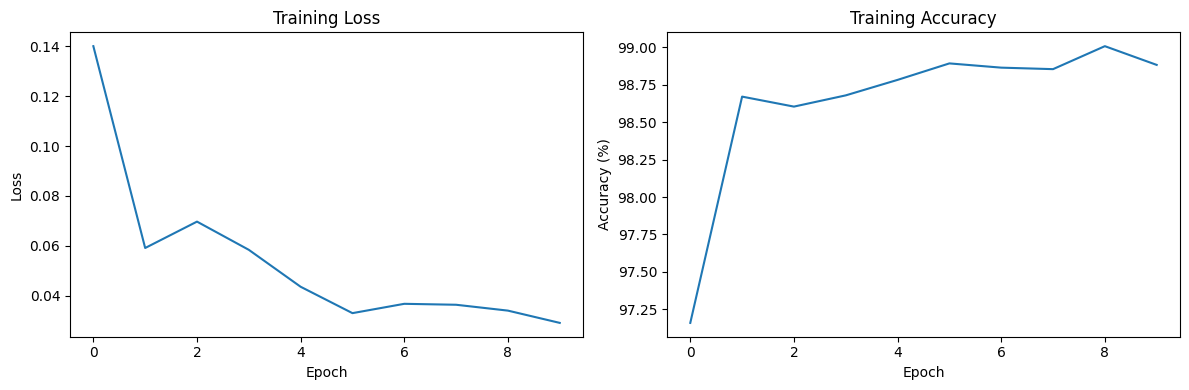

In [ ]:
if __name__ == "__main__":
    trained_agent = train_mnist_dqn()
    plot_training_metrics(trained_agent)

In [ ]:
def predict_single_image(agent, image_index=None):
    """
    Predict a single MNIST image using the trained DQN agent
    image_index: Optional index of image from test set to use
    """
    # Load MNIST dataset
    (_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # If no index specified, choose random
    if image_index is None:
        image_index = np.random.randint(0, len(x_test))

    # Get single image and preprocess
    image = x_test[image_index]
    true_label = y_test[image_index]

    # Preprocess the image
    image_processed = image.astype('float32') / 255.0
    image_processed = image_processed[..., tf.newaxis]  # Add channel dimension

    # # Get prediction
    # action = agent.select_action(image_processed)

    # print(action)

    # Set epsilon to 0 to ensure deterministic prediction
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    pred_label = agent.select_action(image_processed)
    agent.epsilon = original_epsilon

    # Display image and predictions
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f'True Label: {true_label}\nPredicted Label: {pred_label}')
    plt.axis('off')
    plt.show()

    return pred_label, true_label

4


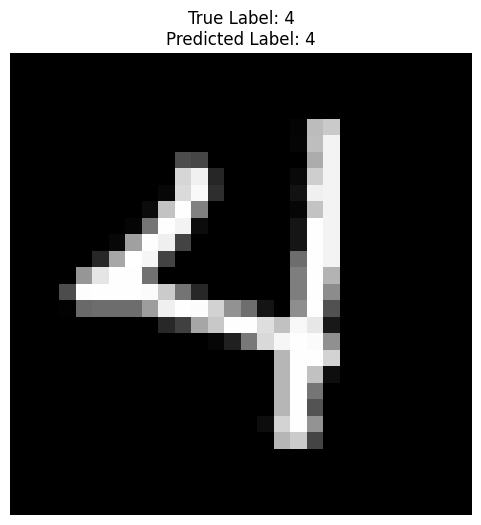

In [ ]:
pred_label, true_label = predict_single_image(trained_agent)

In [ ]:
trained_agent.training_loss

[0.14005416603111387,
 0.05914990133753045,
 0.06972567976732255,
 0.058414891667039684,
 0.04361350394498074,
 0.03303598228114952,
 0.036774661029676574,
 0.036397731097320904,
 0.034045974152911565,
 0.029130066079058544]

In [ ]:
trained_agent.training_accuracy

[97.16,
 98.67,
 98.60333333333334,
 98.67833333333333,
 98.78166666666667,
 98.89166666666667,
 98.86333333333333,
 98.85333333333334,
 99.00666666666666,
 98.88166666666666]

In [ ]:
training_loss = [0.14005416603111387, 0.05914990133753045,
 0.06972567976732255,
 0.058414891667039684,
 0.04361350394498074,
 0.03303598228114952,
 0.036774661029676574,
 0.036397731097320904,
 0.034045974152911565,
 0.029130066079058544]

In [ ]:
training_accuracy = [97.16,
 98.67,
 98.60333333333334,
 98.67833333333333,
 98.78166666666667,
 98.89166666666667,
 98.86333333333333,
 98.85333333333334,
 99.00666666666666,
 98.88166666666666]

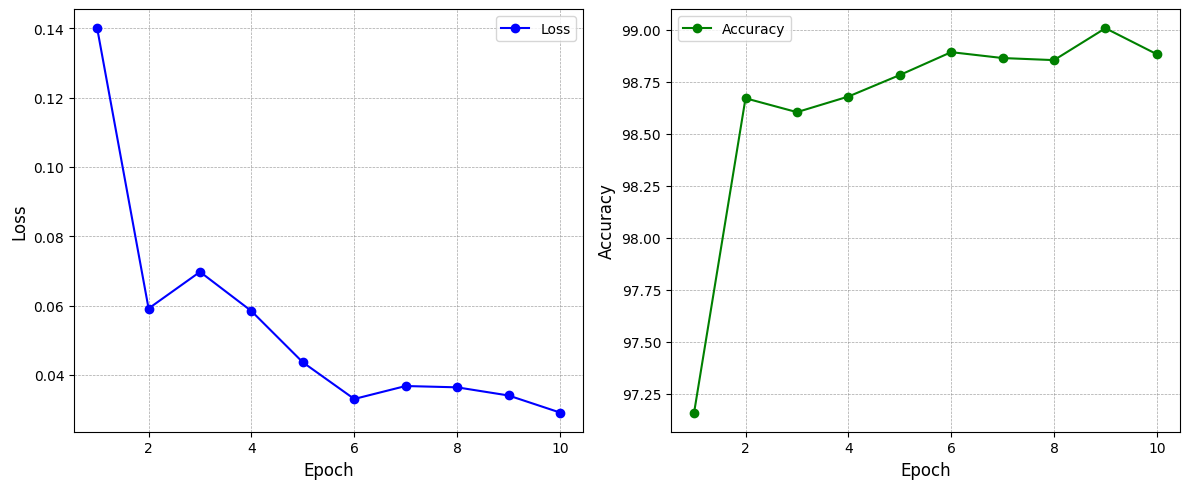

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, training_loss, marker='o', color='b', label='Loss')

axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axes[0].legend(fontsize=10)


axes[1].plot(epochs, training_accuracy, marker='o', color='g', label='Accuracy')

axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axes[1].legend(fontsize=10)

plt.tight_layout()

plt.savefig("loss_accuracy_graphs.pdf", format='pdf')
plt.show()